# Performance across categories

This notebook relates to the performance across categories section of the associated master thesis'

Load in examples and predictions

In [6]:
import torch
import pandas as pd
import json

In [ ]:
examples_path = "../cuad_training/cuad_lightning/out/dataset-name_CUAD_model-type_roberta_only-first-ans_True_doc-stride_256_dataset-type_eval_predict-file-version_test_examples"
examples = torch.load(examples_path)

prediction_path = "../cuad_training/cuad_lightning/out/predictions/dataset-name_CUAD_model-type_roberta_only-first-ans_True_doc-stride_256_dataset-type_eval_predict-file-version_test_predtype_test_model-name_roberta_rb_s_checkpoint_test_original_global-step_6466_epoch13_nbest_predictions.json"
with open(prediction_path, "r") as f:
    preds = json.load(f)

json_test_dict_path = "../data/test.json"
with open(json_test_dict_path, "r") as f:
    json_test_dict = json.load(f)

Import the evaluation stuff

In [8]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../cuad_training/cuad_lightning/')
from utils import get_raw_scores_nbest, apply_no_ans_threshold,make_eval_dict,merge_eval,find_all_best_thresh

In [9]:
def squad_evaluate_nbest(examples, n_best_path, no_answer_probs=None, no_answer_probability_threshold=1.0, n_best_size=3):
    """Just like squad_evaluate, but instead allowing for nbest predictions which just the best score

    Args:
        examples (_type_): Squad examples
        n_best_path (_type_): path to the best nbest predictions file
        no_answer_probs (_type_, optional): same. Defaults to None.
        no_answer_probability_threshold (float, optional): same. Defaults to 1.0.
        n_best_size (int, optional): How many predictions to look at. Defaults to 3.

    Returns:
        _type_: _description_
    """
    # load preds
    with open(n_best_path, 'r') as f:
        preds = json.load(f)

    qas_id_to_has_answer = {example.qas_id: bool(
        example.answers) for example in examples}
    has_answer_qids = [qas_id for qas_id,
                       has_answer in qas_id_to_has_answer.items() if has_answer]
    no_answer_qids = [qas_id for qas_id,
                      has_answer in qas_id_to_has_answer.items() if not has_answer]

    if no_answer_probs is None:
        no_answer_probs = {k: 0.0 for k in preds}

    exact, f1 = get_raw_scores_nbest(examples, preds, n_best_size)

    exact_threshold = apply_no_ans_threshold(
        exact, no_answer_probs, qas_id_to_has_answer, no_answer_probability_threshold
    )
    f1_threshold = apply_no_ans_threshold(
        f1, no_answer_probs, qas_id_to_has_answer, no_answer_probability_threshold)

    evaluation = make_eval_dict(exact_threshold, f1_threshold)

    if has_answer_qids:
        has_ans_eval = make_eval_dict(
            exact_threshold, f1_threshold, qid_list=has_answer_qids)
        merge_eval(evaluation, has_ans_eval, "HasAns")

    if no_answer_qids:
        no_ans_eval = make_eval_dict(
            exact_threshold, f1_threshold, qid_list=no_answer_qids)
        merge_eval(evaluation, no_ans_eval, "NoAns")

    if no_answer_probs:
        find_all_best_thresh(evaluation, preds, exact, f1,
                             no_answer_probs, qas_id_to_has_answer)

    return evaluation, exact, f1

In [21]:
eval_, exact, f1 = squad_evaluate_nbest(examples, prediction_path,n_best_size=1)

In [22]:
# create the nbest=1 df
data = []
for k,v in exact.items():
    # question name, question type, value, category
    data.append([k,k.split("__")[1],v,"em nbest=1"])

for k,v in f1.items():
    # question name, question type, value, category
    data.append([k,k.split("__")[1],v,"f1 nbest=1"])

eval_, exact, f1 = squad_evaluate_nbest(examples, prediction_path, n_best_size=3)

# add the nbest=3 to df
for k,v in exact.items():
    # question name, question type, value, category
    data.append([k,k.split("__")[1],v,"em nbest=3"])

for k,v in f1.items():
    # question name, question type, value, category
    data.append([k,k.split("__")[1],v,"f1 nbest=3"])

Add aupr to the mix

In [14]:
from evaluate import get_results,get_answers

In [16]:
# fake args class
class Args:
    def __init__(self):       
        self.model_name = 3
        self.model_version = 1.0
# Iterate question types and calculate the results

aupr_data = []
for question_type in set([x.split("__")[1] for x in preds.keys()]):
    gt_dict = get_answers(json_test_dict)
    rs = get_results(Args(), prediction_path, gt_dict, gt_dict_extract_answers=False, filter=question_type)
    aupr_data.append([question_type,'aupr',rs['aupr']])
gt_dict = get_answers(json_test_dict)


Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4040 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with answers
Removing 4080 examples with 

In [23]:
df = pd.DataFrame(data, columns=["question_name","question_type","value","category"])

In [24]:
df = df.groupby(["question_type","category"]).mean().reset_index()
df2 = pd.DataFrame(aupr_data, columns=["question_type","category","value"])
df_final = pd.concat([df, df2])

for use on server and locally

In [25]:
df_final.to_csv('Performance_across_cat.csv')

In [20]:
df_final = pd.read_csv('Performance_across_cat.csv')

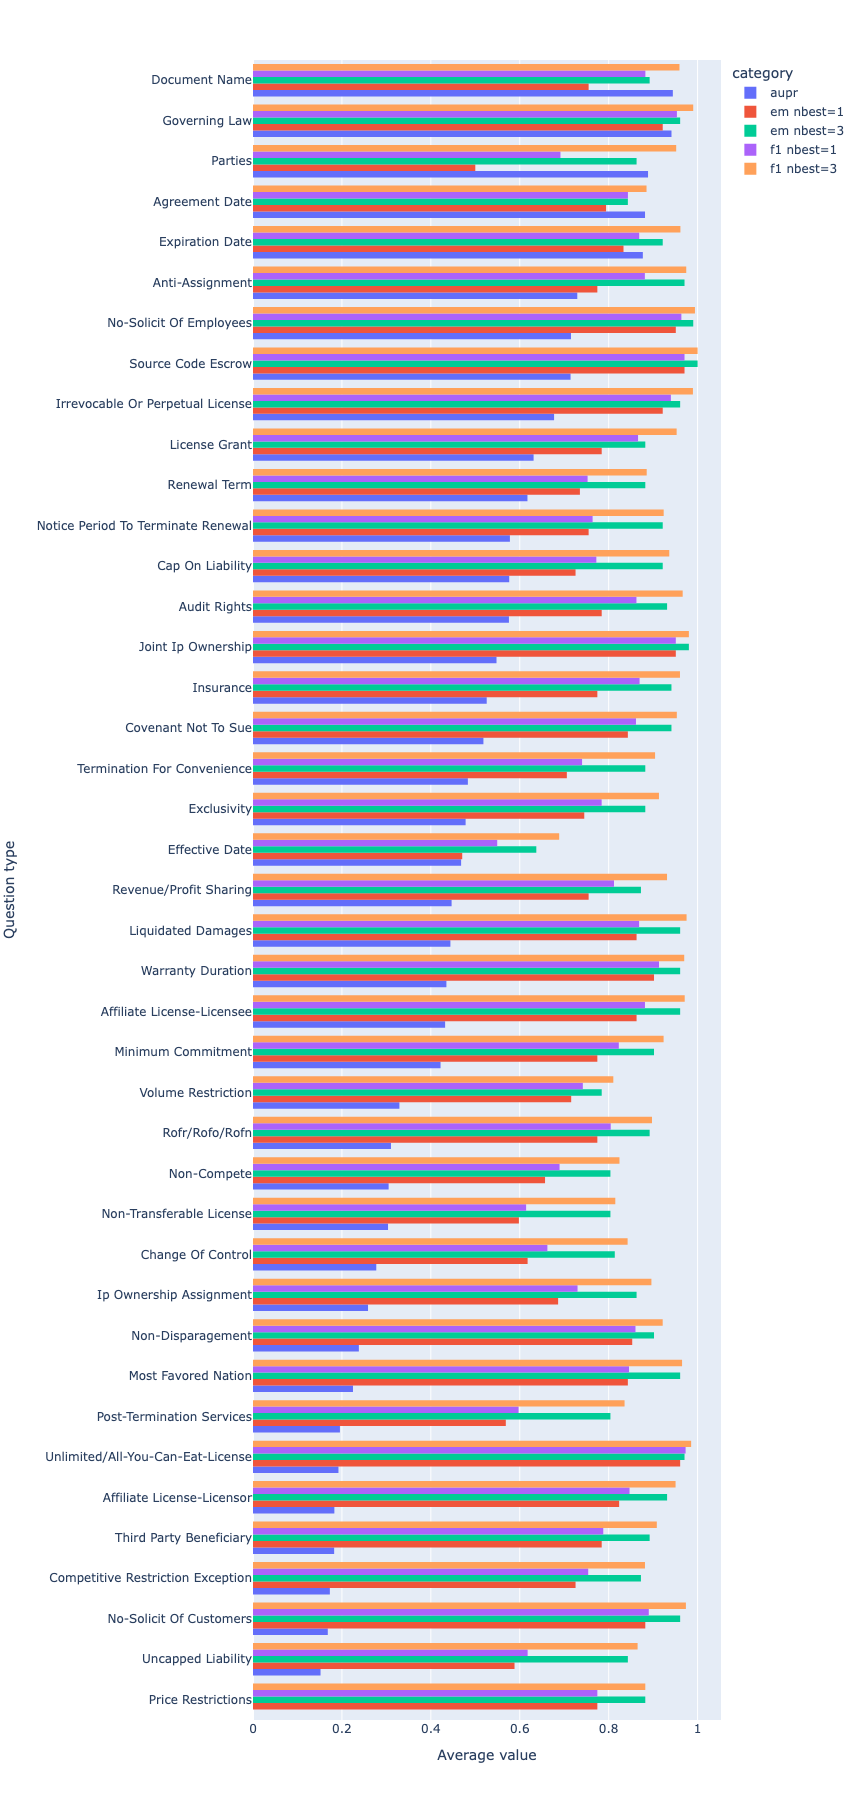

In [29]:
import plotly.express as px
df_final = df_final.sort_values(by=["category",'value'])
fig = px.histogram(df_final, y="question_type", x="value",
             color='category', barmode='group', orientation='h',width=800, height=1800)
fig.update_layout(
    xaxis_title="Average value",
    yaxis_title="Question type",
)
fig.show()
